# Привет! Тут мы анализируем русскоязычные твиты :)

#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Вместо BoW попробовать tf-idf, сравнить результаты
4. Попробовать предобученные эмбеддинги для слов:
    - скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
    - установить пакет gensim для использования предобученной модели
    - загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
    - визуализировать результат
5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.
6. Полученные визуализации показать преподавателю    

Если будут вопросы - обращайтесь :)

## I. Импортим нужные библиотеки

In [1]:
import xmltodict
import re
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from gensim.models import KeyedVectors

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alexandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Alexandr\AppData\Roaming\Python\Python36\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## II. Определяем функции с парсингом входных данных 

In [2]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

## III. Обрабатываем наши данные

In [14]:
train_filename = "../data/SentiRuEval_2016/bank_train_2016.xml"
test_filename = "../data/SentiRuEval_2016/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)
train[50:60]

text  answer     company  \
50  В наш сбербанк пришел американец и попросил сф...       1    sberbank   
51  http://t.co/XifphFemGQ Втб 24 банк взять креди...       0         vtb   
52  Отсрочка платежа по кредиту россельхозбанк htt...       0        rshb   
53  Заявление анкета на ипотечный кредит втб 24 ht...       0         vtb   
54  RT @360_tv_ru: #Канада ввела санкции против 10...      -1     gazprom   
55  За первое полугодие 2014 года Сбербанк России ...       1    sberbank   
56  Условия частично досрочного погашения кредита ...       0  raiffeisen   
57  Расчет кредита наличными сбербанк http://t.co/...       0    sberbank   
58  Сравнить кредитные ставки в сбербанке газпромб...       0    sberbank   
59  Сравнить кредитные ставки в сбербанке газпромб...       0     gazprom   

    sample_id  
50         48  
51         49  
52         50  
53         51  
54         52  
55         53  
56         54  
57         55  
58         56  
59         56

In [17]:
train.text[56]

'Условия частично досрочного погашения кредита в райффайзенбанке http://t.co/EzFc16VMis'

## IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [4]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [5]:
train.head()

text  answer     company  \
0                 url Взять кредит тюмень альфа банк       0    alfabank   
1                Мнение о кредитной карте втб 24 url       0         vtb   
2  «Райффайзенбанк»: Снижение ключевой ставки ЦБ ...       0  raiffeisen   
3  Современное состояние кредитного поведения в р...       0    sberbank   
4         user user Главное чтоб банки СБЕР и ВТБ!!!       1    sberbank   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [6]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [27]:
test.head()

text  answer company  \
0           #Автокредит в россельхозбанк в череповце       0    rshb   
1  RT user url #Кредитный калькулятор россельхозб...       0    rshb   
2              #Автокредит в россельхозбанк 2012 url       0    rshb   
3        RT user #Кредитные карты россельхозбанк url       0    rshb   
4      RT user #Кредиты в россельхозбанке ижевск url       0    rshb   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

## V. BoW векторайзер с 100 самыми частотными словами

In [28]:
vectorizer = CountVectorizer(max_features=100)

In [29]:
X = vectorizer.fit_transform(train['text'])

In [30]:
X.shape

(10725, 100)

## VI. Смотрим на результаты

In [13]:
decomposition = TSNE(n_components=2)

In [14]:
%%time
X_embedded = decomposition.fit_transform(X.toarray())

Wall time: 1min 4s


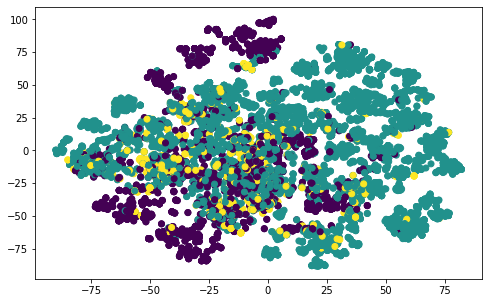

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(*np.transpose(X_embedded), c=train['answer'])
plt.show()

# HW PART
2. Запустить этот же ноутбук на данных ___ttk___
3. Вместо BoW попробовать tf-idf, сравнить результаты
4. Попробовать предобученные эмбеддинги для слов:
    - скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
    - установить пакет gensim для использования предобученной модели
    - загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
    - визуализировать результат
5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.
6. Полученные визуализации показать преподавателю    


In [19]:
companies = {}

def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df


train_filename = "../data/SentiRuEval_2016/tkk_train_2016.xml"
test_filename = "../data/SentiRuEval_2016/tkk_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)
train[50:60]

text  answer  company  \
50  ОАО &amp;quot;Мобильные ТелеСистемы&amp;quot; ...       0      mts   
51  Незаконная задолженность МТС - минус 9 миллион...      -1      mts   
52  «МегаФон» в Вологодской области: полгода на ск...       1  megafon   
53  RT @EvaKobb: МТС Россия прислала жителям Херсо...      -1      mts   
54  «МТС Урал» отмечает рост продаж мобильных устр...       1      mts   
55  У группы есть "голодный телефон". Деньги, кото...       0  beeline   
56  http://t.co/RrwH81dENe Сотовый оператор МТС вв...       0      mts   
57  10 июля 2014 года вещание телеканала CTC Love ...       0  beeline   
58  RT @OliverLoveFrank: ЕСЛИ МОБ.ИНЕТ ОПЯТЬ НЕ ЗА...      -1      mts   
59  мтс банк ростовский филиал руководство http://...       0      mts   

    sample_id  
50         53  
51         54  
52         55  
53         56  
54         57  
55         58  
56         59  
57         60  
58         61  
59         62

In [23]:
train.text[59]

'мтс банк ростовский филиал руководство http://t.co/Ksi2QXrhr9 #ростовский #банк'

In [44]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)
train.head()

text  answer  company  \
0  user Максим, Вашем письмо мы получили. Наши со...       0  beeline   
1     «Мегафон» стал владельцем 50% акций «Евросети»       0  megafon   
2  RT user “user МТС Россия прислала жителям Херс...      -1      mts   
3         ВИДЕО: url Реклама со смехом МТС - Супер 0       1      mts   
4  user потому что МТС достало, а пчел ненавижу с...      -1      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

In [47]:
print(train['answer'].value_counts())
test.head()

 0    5213
-1    2611
 1    1385
Name: answer, dtype: int64


text  answer  company  \
0  RT vzglyad: По делу о работе МТС в Узбекистане...      -1      mts   
1         RT user url #Кредитные карты мегафон банка       0  megafon   
2          #Оформить кредитную карту в банке мтс url       0      mts   
3  #Как перевести деньги с билайна на кредитную к...       0  beeline   
4  #Начальник отдела кредитного контроля оао мтс ...       0      mts   

   sample_id  
0          1  
1          2  
2          3  
3          4  
4          5

## BOW + TSNE

In [51]:
bow_vectorizer = CountVectorizer(max_features=100)
X_bow = bow_vectorizer.fit_transform(train['text'])
X.shape
tsne_decomposition = TSNE(n_components=2)

In [52]:
%%time
X_embedded_bow_tsne = tsne_decomposition.fit_transform(X_bow.toarray())

Wall time: 1min 3s


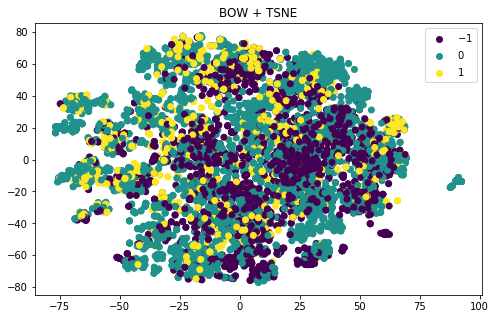

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_bow_tsne), c=train['answer'])
plt.title('BOW + TSNE')
ax.legend(*scatter.legend_elements())
plt.show()

# BOW + PCA

In [76]:
pca_decomposition = PCA(n_components=2)

In [77]:
%%time
X_embedded_bow_pca = pca_decomposition.fit_transform(X_bow.toarray())

Wall time: 97 ms


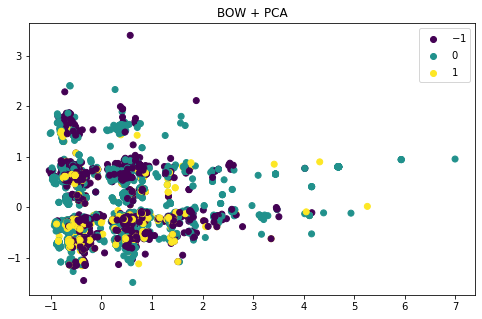

In [78]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_bow_pca), c=train['answer'])
plt.title('BOW + PCA')
ax.legend(*scatter.legend_elements())
plt.show()

# BOW + RP

In [81]:
%%time
rp_decomposition = GaussianRandomProjection(n_components=2)

X_embedded_bow_rp = rp_decomposition.fit_transform(X_bow.toarray())

Wall time: 13 ms


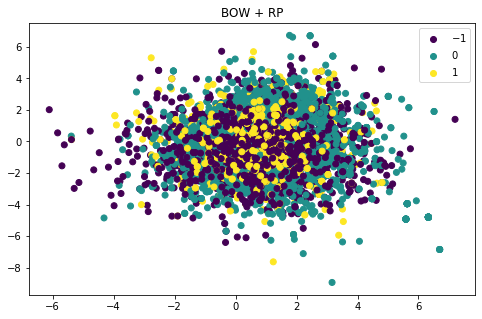

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_bow_rp), c=train['answer'])
plt.title('BOW + RP')
ax.legend(*scatter.legend_elements())
plt.show()

# TF-IDF + TSNE

In [83]:
%%time

tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(train['text'])
X.shape
tsne_decomposition = TSNE(n_components=2)

X_embedded_tfidf_tsne = tsne_decomposition.fit_transform(X_tfidf.toarray())

Wall time: 49.8 s


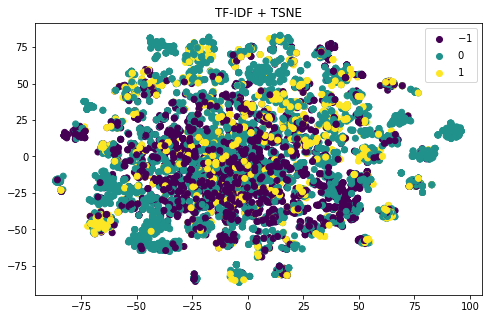

In [84]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_tfidf_tsne), c=train['answer'])
plt.title('TF-IDF + TSNE')
ax.legend(*scatter.legend_elements())
plt.show()

# TF-IDF + PCA

In [85]:
%%time
pca_decomposition = PCA(n_components=2)
X_embedded_tfidf_pca = pca_decomposition.fit_transform(X_tfidf.toarray())

Wall time: 100 ms


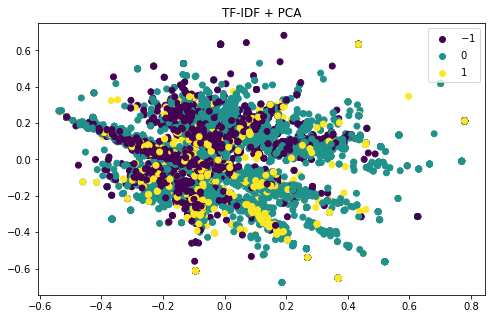

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_tfidf_pca), c=train['answer'])
plt.title('TF-IDF + PCA')
ax.legend(*scatter.legend_elements())
plt.show()

# TF-IDF + RP

In [87]:
%%time
rp_decomposition = GaussianRandomProjection(n_components=2)

X_embedded_tfidf_rp = rp_decomposition.fit_transform(X_tfidf.toarray())

Wall time: 8.98 ms


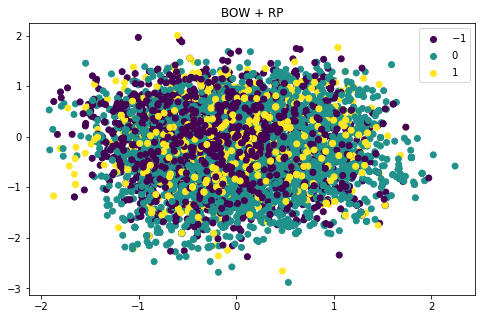

In [89]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_tfidf_rp), c=train['answer'])
plt.title('BOW + RP')
ax.legend(*scatter.legend_elements())
plt.show()

# FASTTEXT

In [202]:
import re

# Я бы и стемматизацию сделал, но она слишком долго делается...
def tag(word):
    if len(re.findall('\w', word)) == 0:
        return word
    m = Mystem()
    processed = m.analyze(word)[0]
    if 'analysis' not in processed.keys() or len(processed['analysis']) == 0:
        return processed['text']
    lemma = processed["analysis"][0]["lex"].lower().strip()
    return lemma


path = '../models/ft/model.model'
ft = KeyedVectors.load(path)

In [196]:
%%time
preprocess = lambda x: np.mean(list(map(ft.get_vector, nltk.word_tokenize(x.lower(), language='russian'))), axis=0)
X_ft = train.text.apply(preprocess)
X_ft = np.array([np.array(i) for i in X_ft.values])

Wall time: 5.85 s


In [199]:
pca_decomposition = PCA(n_components=2)
X_embedded_ft_pca = pca_decomposition.fit_transform(X_ft)

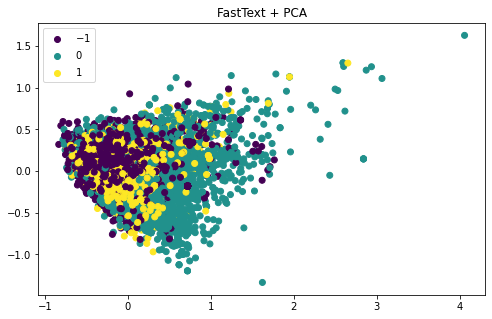

In [201]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_ft_pca), c=train['answer'])
plt.title('FastText + PCA')
ax.legend(*scatter.legend_elements())
plt.show()

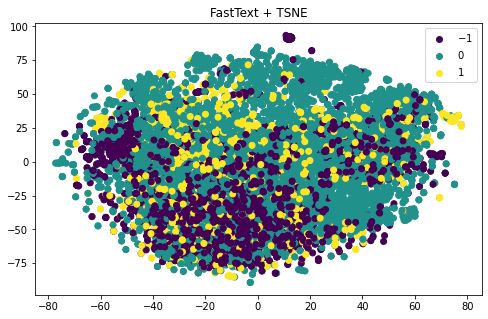

Wall time: 2min 5s


In [203]:
%%time
tsne_decomposition = TSNE(n_components=2)

X_embedded_ft_tsne = tsne_decomposition.fit_transform(X_ft)

fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_ft_tsne), c=train['answer'])
plt.title('FastText + TSNE')
ax.legend(*scatter.legend_elements())
plt.show()

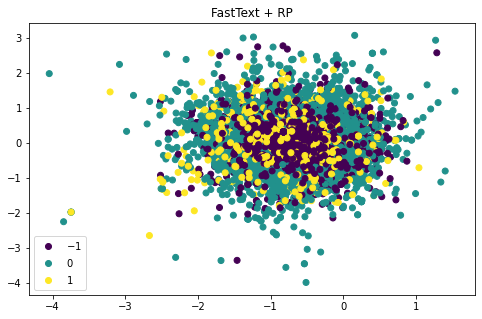

In [204]:
rp_decomposition = GaussianRandomProjection(n_components=2)

X_embedded_ft_rp = rp_decomposition.fit_transform(X_ft)

fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(*np.transpose(X_embedded_ft_rp), c=train['answer'])
plt.title('FastText + RP')
ax.legend(*scatter.legend_elements())
plt.show()